<a href="https://colab.research.google.com/github/sanjsvk/TripAdvisor-Hotel-Reviews/blob/main/TripAdvisor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [82]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as L
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from wordcloud import WordCloud 
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns

import numpy as np 
import pandas as pd

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords

import random as rn

import re

In [83]:
seed_value = 12
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
rn.seed(seed_value)

In [84]:
path = '/content/drive/MyDrive/TripAdvisor/'
data = pd.read_csv(path + 'tripadvisor_hotel_reviews.csv')
data.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [85]:
print("Length of data:",len(data))

Length of data: 20491


In [86]:
data.isna().sum()

Review    0
Rating    0
dtype: int64

####Rating Counts

In [87]:
rating_counts = data['Rating'].value_counts()
print(rating_counts)
fig = go.Figure([go.Bar(x = rating_counts.index, y = rating_counts.values)])
fig.update_layout(title = 'Rating Counts')
fig.show()

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64


####Most commonly used words

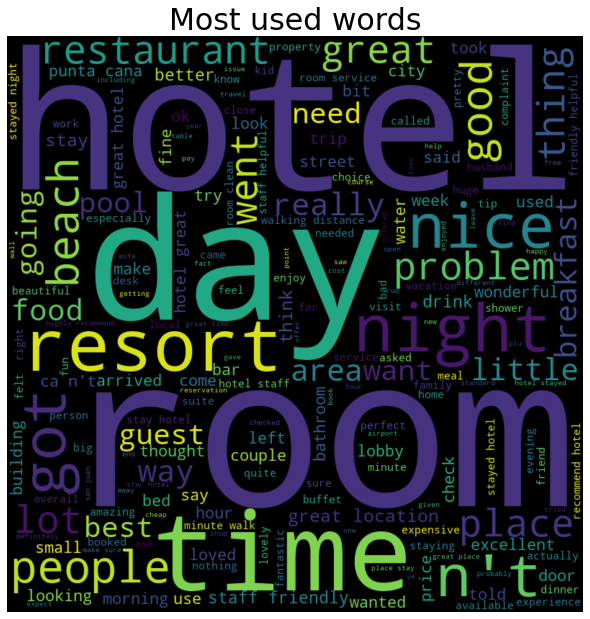

In [88]:
wordcloud = WordCloud(width = 800, height = 800,
                          background_color ='black',
                          min_font_size = 10
                         ).generate(" ".join(data['Review'].values))
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Most used words",fontsize=30)
plt.show() 

In [89]:
X = data['Review'].copy()
y = data['Rating'].copy()

###Data Cleaning

In [90]:
nltk.download('stopwords')

def data_cleaner(review):
  #remove digits
  review = re.sub(r'\d+',' ',review)
  #remove stop words
  review = review.split()
  review = " ".join([word for word in review if not word in stop_words])
  #stemming
  #review = " ".join([ps.stem(w) for w in review])

  return review
ps = PorterStemmer()
stop_words = stopwords.words('english')

X_cleaned = X.apply(data_cleaner)
X_cleaned.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0    nice hotel expensive parking got good deal sta...
1    ok nothing special charge diamond member hilto...
2    nice rooms * experience hotel monaco seattle g...
3    unique, great stay, wonderful time hotel monac...
4    great stay great stay, went seahawk game aweso...
Name: Review, dtype: object

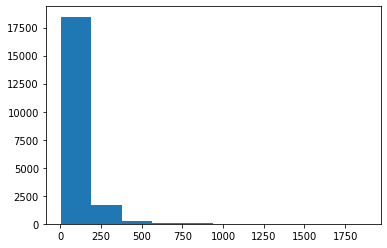

In [91]:
length_dist = [len(x.split(" ")) for x in X_cleaned]
plt.hist(length_dist)
plt.show()

###Tokenize the words

In [92]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_cleaned)

X = tokenizer.texts_to_sequences(X_cleaned)

max_length = max([len(x) for x in X])
vocab_size = len(tokenizer.word_index)+1
exp_sen = 1

print("Vocabulary size: {}".format(vocab_size))
print("max length of sentence: {}".format(max_length))
print("\nExample:\n")
print("Sentence:\n{}".format(X_cleaned[exp_sen]))
print("\nAfter tokenizing :\n{}".format(X[exp_sen]))

X = pad_sequences(X, padding='post', maxlen=350)
print("\nAfter padding :\n{}".format(X[exp_sen]))

Vocabulary size: 49536
max length of sentence: 1940

Example:

Sentence:
ok nothing special charge diamond member hilton decided chain shot th anniversary seattle, start booked suite paid extra website description not, suite bedroom bathroom standard hotel room, took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast, got kidding, embassy suits sitting room bathroom bedroom unlike kimpton calls suite, day stay offer correct false advertising, send kimpton preferred guest website email asking failure provide suite advertised website reservation description furnished hard copy reservation printout website desk manager duty reply solution, send email trip guest survey follow email mail, guess tell concerned guest.the staff ranged indifferent helpful, asked desk good breakfast spots neighborhood hood told hotels, gee best breakfast spots seattle / block away convenient hotel know exist, arrived late

In [93]:
encoding = {1: 0,
            2: 1,
            3: 2,
            4: 3,
            5: 4
           }

labels = ['1', '2', '3', '4', '5']
           
y.replace(encoding, inplace=True)

###Model

In [94]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=67, stratify=y
)

In [95]:
# hyper parameters
EPOCHS = 3
BATCH_SIZE = 100
embedding_dim = 16
units = 76

model = tf.keras.Sequential([
    L.Embedding(vocab_size, embedding_dim, input_length=X.shape[1]),
    L.Bidirectional(L.LSTM(units,return_sequences=True)),
    #L.LSTM(units,return_sequences=True),
    L.Conv1D(64,3),
    L.MaxPool1D(),
    L.Flatten(),
    L.Dropout(0.5),
    L.Dense(128, activation="relu"),
    L.Dropout(0.5),
    L.Dense(64, activation="relu"),
    L.Dropout(0.5),
    L.Dense(5, activation="softmax")
])

model.compile(loss=SparseCategoricalCrossentropy(),
              optimizer='adam',metrics=['accuracy']
             )

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 350, 16)           792576    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 350, 152)          56544     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 348, 64)           29248     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 174, 64)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 11136)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 11136)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)              

In [96]:
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_split=0.12, batch_size=BATCH_SIZE, verbose=2)

Epoch 1/3
121/121 - 86s - loss: 1.2631 - accuracy: 0.4494 - val_loss: 1.0374 - val_accuracy: 0.5340
Epoch 2/3
121/121 - 84s - loss: 0.9582 - accuracy: 0.5599 - val_loss: 0.9173 - val_accuracy: 0.5752
Epoch 3/3
121/121 - 85s - loss: 0.7943 - accuracy: 0.6477 - val_loss: 0.9328 - val_accuracy: 0.5856


In [97]:
fig = px.line(data_frame = history.history, y=history.history['accuracy'], title = 'Accuracy', labels={'x': 'epoch', 'y': 'accuracy'})
fig.add_scatter(y=history.history['val_accuracy'], mode = 'lines')
fig.show()

In [98]:
fig = px.line(history.history, y=history.history['loss'], title = 'Loss', labels={'x': 'epoch', 'y': 'Loss'})
fig.add_scatter(y=history.history['val_loss'], mode = 'lines')
fig.show()

In [99]:
pred = model.predict_classes(X_test)

####Predictions

In [100]:
pd.DataFrame(pred).head()

,0
0,2
1,3
2,2
3,3
4,4


In [101]:
print('Accuracy: {}'.format(accuracy_score(pred, y_test)))
print("Mean absolute error: {}".format(mean_absolute_error(pred,y_test)))
print("Root mean square error: {}".format(np.sqrt(mean_squared_error(pred,y_test))))

Accuracy: 0.6000295726748485
Mean absolute error: 0.46251663462960224
Root mean square error: 0.7837247326721926


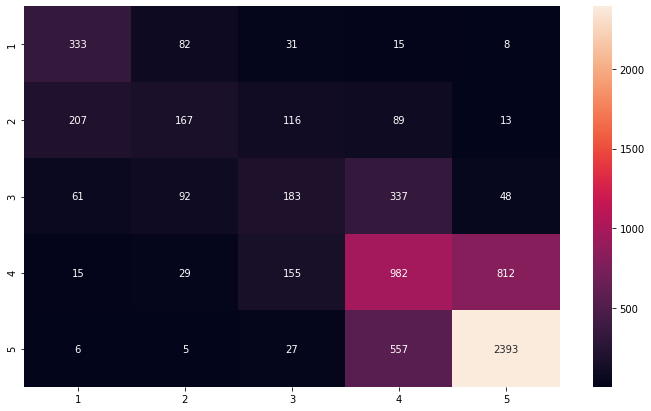

In [102]:
conf = confusion_matrix(y_test, pred)

cm = pd.DataFrame(
    conf, index = [i for i in labels],
    columns = [i for i in labels]
)
 
plt.figure(figsize = (12,7))
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

In [103]:
print(classification_report(y_test, pred, target_names=labels))

              precision    recall  f1-score   support

           1       0.54      0.71      0.61       469
           2       0.45      0.28      0.35       592
           3       0.36      0.25      0.30       721
           4       0.50      0.49      0.49      1993
           5       0.73      0.80      0.76      2988

    accuracy                           0.60      6763
   macro avg       0.51      0.51      0.50      6763
weighted avg       0.58      0.60      0.59      6763



---